In [9]:

import os
import torch


tkwargs = {
    "dtype": torch.float64,
    "device": torch.device("cpu"),
}

import botorch
from botorch.test_functions.multi_objective import DTLZ1

import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP, ModelListGP
from botorch.sampling import SobolQMCNormalSampler
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.gp_sampling import get_gp_samples
from botorch.acquisition.analytic import PosteriorMean
from botorch.models.deterministic import GenericDeterministicModel
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning
)
from botorch.utils.multi_objective import Hypervolume


import numpy as np
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import HV
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import Problem

import matplotlib.pyplot as plt

# Multiobjective Algo

In [3]:
def hv_truncation(
        sample_pf,
        ref_point,
        output_size,
    ):  
    '''
    Args:
        output_size: The desired number of Pareto points.
        sample_pf: A `P x M`-dim Numpy array containing the oversampled Pareto front .
    '''
    M = sample_pf.shape[-1]
    indices = []
    sample_pf = torch.from_numpy(sample_pf)
    ref_point = torch.from_numpy(ref_point)

    for k in range(output_size):
        if k == 0:
            hypercell_bounds = torch.zeros(2, M)
            hypercell_bounds[0] = ref_point
            hypercell_bounds[1] = 1e+10
        else:
            partitioning = FastNondominatedPartitioning(
                ref_point=ref_point, Y=fantasized_pf
            )

            hypercell_bounds = partitioning.hypercell_bounds

        # `1 x num_boxes x M`
        lo = hypercell_bounds[0].unsqueeze(0)
        up = hypercell_bounds[1].unsqueeze(0)
        # compute hv
        hvi = torch.max(
            torch.min(sample_pf.unsqueeze(-2), up) - lo,
            torch.zeros(lo.shape)
        ).prod(dim=-1).sum(dim=-1)

        # zero out pending points
        hvi[indices] = 0
        # store update
        am = torch.argmax(hvi).tolist()
        indices = indices + [am]

        if k == 0:
            fantasized_pf = sample_pf[am:am + 1, :]
        else:
            fantasized_pf = torch.cat([fantasized_pf, sample_pf[am:am + 1, :]],
                                    dim=0)

    # indices = torch.tensor(indices)
    return indices

## DTLZ2

In [58]:
x_dim = 6
num_objectives = 2

pymoo_problem = get_problem(
    "dtlz2",
    n_var=x_dim,
    n_obj=num_objectives,
) # minimizing

obj_func = botorch.test_functions.multi_objective.DTLZ2(
    dim=x_dim,
    num_objectives=num_objectives,
    negate=True,
)
ref_val = obj_func._ref_val # This doesn't change even if negate=True!!!!!
ref_point = np.array([ref_val] * num_objectives)

pymoo_pf = pymoo_problem.pareto_front()
# pymoo_ref_point = np.array([11] * num_objectives)
pymoo_ref_point = ref_point

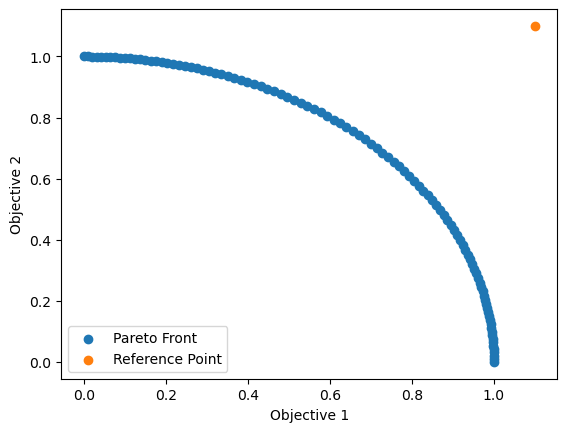

In [72]:
# plot pymoo pareto front and reference point
fig, ax = plt.subplots()
ax.scatter(pymoo_pf[:, 0], pymoo_pf[:, 1], label="Pareto Front")
ax.scatter(pymoo_ref_point[0], pymoo_ref_point[1], label="Reference Point")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.legend()
plt.show()



In [59]:
test_x = torch.rand(10, x_dim, **tkwargs)
# compute pymoo value of the test_x
pymoo_y = []
for x in test_x:
    x_ = x.numpy()
    # print(x_)
    y = pymoo_problem.evaluate(x_)
    # print(y)
    pymoo_y.append(y)

pymoo_y = np.array(pymoo_y)

botorch_y = obj_func(test_x).numpy()

In [60]:
ind_pymoo = HV(ref_point=pymoo_ref_point)
ind_pymoo(pymoo_pf)

0.4201303514688245

In [61]:
class BotorchProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=x_dim,
            n_obj=num_objectives,
            n_constr=0,
            xl=np.array([0] * x_dim),
            xu=np.array([1] * x_dim),
        )

    def _evaluate(self, x, out, *args, **kwargs):
        xt = torch.tensor(x)
        out["F"] = -1 * obj_func(xt).numpy()
        return out

botorch_problem = BotorchProblem()
botorch_ref_point = -1 * torch.from_numpy(ref_point)
ind_botorch = Hypervolume(ref_point=botorch_ref_point)
ind_botorch.compute(-torch.from_numpy(pymoo_pf))

0.4201303514688245

In [68]:
botorch_ref_point

tensor([-1.1000, -1.1000], dtype=torch.float64)

In [65]:
aug_pareto_set, aug_pareto_front = [], []
for i in range(5):

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=10,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=10),
        eliminate_duplicates=True,
        seed = np.random.randint(0, 1000),
    )

    result = minimize(
        botorch_problem,
        algorithm,
        ("n_gen", 500),
        save_history=True,
        verbose=False,
    )

    X, F = result.opt.get("X", "F")
    aug_pareto_set.append(X)
    aug_pareto_front.append(F)

pareto_set = np.vstack(aug_pareto_set)
pareto_front = -1 * np.vstack(aug_pareto_front) # turns into max mode

In [66]:
idx = hv_truncation(pareto_front, botorch_ref_point.numpy(), 50)
pareto_set = pareto_set[idx]
pareto_front = pareto_front[idx]

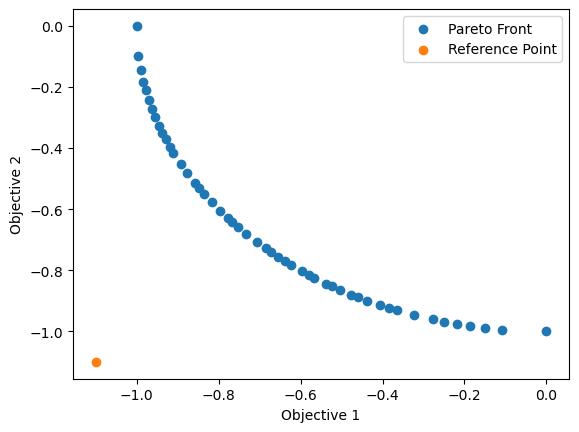

In [73]:
# plot pareto front and reference point
fig, ax = plt.subplots()
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Pareto Front")
ax.scatter(botorch_ref_point[0], botorch_ref_point[1], label="Reference Point")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.legend()
plt.show()

In [71]:
botorch_ref_point

tensor([-1.1000, -1.1000], dtype=torch.float64)

In [75]:
# botorch_ind = HV(ref_point=-botorch_ref_point)
ind_botorch = Hypervolume(ref_point=botorch_ref_point)
x_torch = torch.tensor(pareto_set)
f_values = obj_func(x_torch).squeeze()
ind_botorch.compute(f_values)



0.4167858834490649

In [70]:
negate_f_values = -1 * f_values.numpy()
ind_pymoo = HV(ref_point=pymoo_ref_point)
ind_pymoo(negate_f_values)

0.4167858834490649

## ZDT2

In [4]:
x_dim = 6
num_objectives = 2

pymoo_problem = get_problem(
    # "zdt2",
    "dtlz2",
    n_var=x_dim,
    n_obj=num_objectives,
) # minimizing

pymoo_pf = pymoo_problem.pareto_front()
pymoo_ref_point = np.array([11] * num_objectives)
ind_pymoo = HV(ref_point=pymoo_ref_point)
ind_pymoo(pymoo_pf)

120.32829983335034

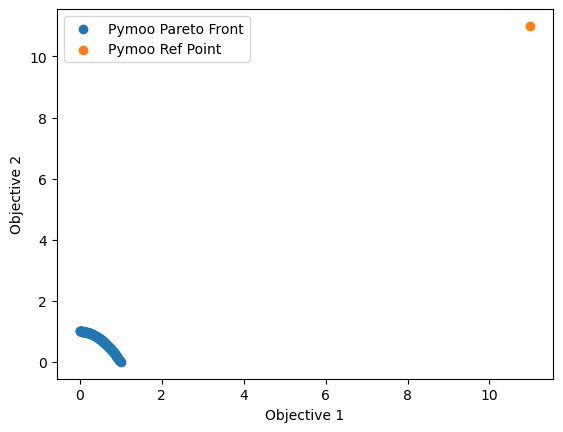

In [5]:
# plot the ref poitn and the pareto front
fig, ax = plt.subplots()
ax.scatter(pymoo_pf[:, 0], pymoo_pf[:, 1], label="Pymoo Pareto Front")
ax.scatter(pymoo_ref_point[0], pymoo_ref_point[1], label="Pymoo Ref Point")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.legend()
plt.show()


In [35]:
obj_func = botorch.test_functions.multi_objective.ZDT2(
    dim=x_dim,
    num_objectives=num_objectives,
    negate=False,
)

class BotorchProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=x_dim,
            n_obj=num_objectives,
            n_constr=0,
            xl=np.array([0] * x_dim),
            xu=np.array([1] * x_dim),
        )

    def _evaluate(self, x, out, *args, **kwargs):
        xt = torch.tensor(x)
        out["F"] = -1 * obj_func(xt).numpy()
        return out

botorch_problem = BotorchProblem()
botorch_ref_point = obj_func.ref_point.numpy() # negative of the pymoo_ref_point

In [7]:
aug_pareto_set, aug_pareto_front = [], []
for i in range(5):

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=10,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=10),
        eliminate_duplicates=True,
        seed = np.random.randint(0, 1000),
    )

    result = minimize(
        botorch_problem,
        algorithm,
        ("n_gen", 500),
        save_history=True,
        verbose=False,
    )

    X, F = result.opt.get("X", "F")
    aug_pareto_set.append(X)
    aug_pareto_front.append(F)

pareto_set = np.vstack(aug_pareto_set)
pareto_front = -1 * np.vstack(aug_pareto_front) # turns into max mode

In [8]:
idx = hv_truncation(pareto_front, botorch_ref_point, 100)
pareto_set = pareto_set[idx]
pareto_front = pareto_front[idx]

In [9]:
botorch_ind = HV(ref_point=-botorch_ref_point)
x_torch = torch.tensor(pareto_set)
f_values = obj_func(x_torch).squeeze().numpy()
botorch_ind(-f_values)

120.3240370603349

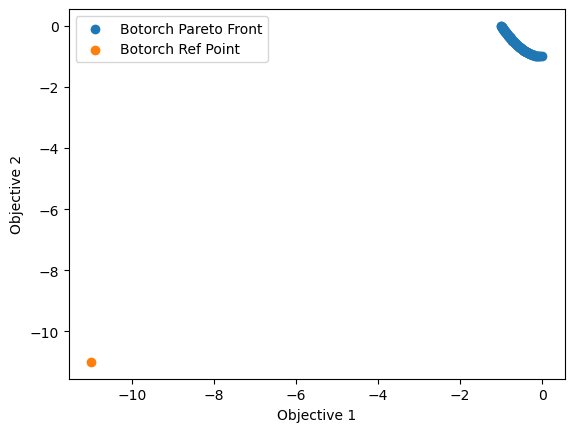

In [10]:
# plot the ref point and the pareto front
fig, ax = plt.subplots()
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Botorch Pareto Front")
ax.scatter(botorch_ref_point[0], botorch_ref_point[1], label="Botorch Ref Point")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.legend()
plt.show()


In [20]:
from botorch.utils.multi_objective import Hypervolume

botorch_hv = Hypervolume(ref_point=torch.from_numpy(botorch_ref_point))

botorch_hv.compute(torch.from_numpy(f_values))

120.32403564453125

# Noise level

In [28]:
from botorch.utils.sampling import draw_sobol_samples

def compute_noise_level(obj_func, noise_level, bounds, num_points=1000, seed=None):
    '''
    Args:
        obj_func: callable
        noise_level: float, percentage of max and min obj_func value
        bounds: torch tensor, shape (2, input_dim)
        num_points: int, number of function evaluations to estimate the noise level
    '''
    inputs = draw_sobol_samples(bounds=bounds, n=num_points, q=1, seed=seed).squeeze(0)
    obj_vals = obj_func(inputs)
    max_vals = torch.max(obj_vals, dim=0).values # shape (num_obj,)
    min_val = torch.min(obj_vals, dim=0).values # shape (num_obj,)
    noise_stds = (max_vals - min_val) * noise_level
    return noise_stds

bounds = torch.vstack([torch.zeros(x_dim), torch.ones(x_dim)]).to(**tkwargs)

inputs = draw_sobol_samples(bounds=bounds, n=1000, q=1, seed=0).squeeze(0)
obj_vals = obj_func(inputs)
max_vals = torch.max(obj_vals, dim=0).values # shape (num_obj,)

min_val = torch.min(obj_vals, dim=0).values # shape (num_obj,)
noise_level = 0.05